<a href="https://colab.research.google.com/github/andrerubeis/andrerubeis/blob/main/final_final_version_MFCCs_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import pickle
import noisereduce as nr
import tqdm

In [4]:
import torch
colab = True

if colab == True:
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.




## 1. Loading Dataset

In [6]:
colab = True

if colab == True:
  path= r'/content/development.csv'
else:
  path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'

df_development = pd.read_csv(path)
df_development

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40
...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40


In [7]:
#Evlauate balancement of dataset
df_development.action.value_counts(), df_development.object.value_counts()

(increase           3823
 decrease           3575
 change language    1113
 activate            791
 deactivate          552
 Name: action, dtype: int64, volume    5000
 heat      2398
 none      1113
 music      791
 lights     552
 Name: object, dtype: int64)

### Evaluate all the existing combinations in the dataset

In [8]:
#Evaluate all the existing combinations in the dataset
df_increase = df_development[df_development['action']=='increase']
df_increase.object.value_counts()

volume    2614
heat      1209
Name: object, dtype: int64

In [9]:
#Evaluate all the existing combinations in the dataset
df_decrease = df_development[df_development['action']=='decrease']
df_decrease.object.value_counts()

volume    2386
heat      1189
Name: object, dtype: int64

In [10]:
#Evaluate all the existing combinations in the dataset
df_change_language = df_development[df_development['action']=='change language']
df_change_language.object.value_counts()

none    1113
Name: object, dtype: int64

In [11]:
#Evaluate all the existing combinations in the dataset
df_activate = df_development[df_development['action']=='activate']
df_activate.object.value_counts()

music    791
Name: object, dtype: int64

In [12]:
#Evaluate all the existing combinations in the dataset
df_deactivate = df_development[df_development['action']=='deactivate']
df_deactivate.object.value_counts()

lights    552
Name: object, dtype: int64

Combinations of actions expressed by humans in the dataset found are the following:
1. increase volume
2. increase heat
3. decrease volume
4. decrease heat
5. change language
6. activate music
7. deactivate lights

According to this, starting from this dataset a new one can be generated containing the audio file with the corresponding label aside referring to the desired action.

### Creating new training dataset
Add a column called labels where in correspondance of each combination has the respective label (ex. if the row has action=increase and object=heat has label 1)

In [13]:
#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development['labels']=0

#df_development_increase_volume = df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume')]
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'volume'), 'labels']='increasevolume'
df_development.loc[(df_development['action'] == 'increase') & (df_development['object'] == 'heat'), 'labels']='increaseheat'

df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'volume'), 'labels']='decreasevolume'
df_development.loc[(df_development['action'] == 'decrease') & (df_development['object'] == 'heat'), 'labels']='decreaseheat'

df_development.loc[(df_development['action'] == 'change language') & (df_development['object'] == 'none'), 'labels']='change languagenone'

df_development.loc[(df_development['action'] == 'activate') & (df_development['object'] == 'music'), 'labels']='activatemusic'
df_development.loc[(df_development['action'] == 'deactivate') & (df_development['object'] == 'lights'), 'labels']='deactivatelights'

df_development
#df_development.labels.value_counts() #check

,Id,path,speakerId,action,object,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange,labels
0,0,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0a312...,2BqVo8kVB2Skwgyb,change language,none,advanced,English (United States),English (United States),female,22-40,change languagenone
1,1,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/0ee42...,2BqVo8kVB2Skwgyb,activate,music,advanced,English (United States),English (United States),female,22-40,activatemusic
2,2,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/1d9f3...,2BqVo8kVB2Skwgyb,deactivate,lights,advanced,English (United States),English (United States),female,22-40,deactivatelights
3,3,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/269fc...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,increasevolume
4,4,dsl_data/audio/speakers/2BqVo8kVB2Skwgyb/5bbda...,2BqVo8kVB2Skwgyb,increase,volume,advanced,English (United States),English (United States),female,22-40,increasevolume
...,...,...,...,...,...,...,...,...,...,...,...
9849,9849,dsl_data/audio/speakers/vnljypgejkINbBAY/4fb3d...,vnljypgejkINbBAY,decrease,volume,native,English (United States),English (United States),male,22-40,decreasevolume
9850,9850,dsl_data/audio/speakers/vnljypgejkINbBAY/59e6a...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights
9851,9851,dsl_data/audio/speakers/vnljypgejkINbBAY/5c81c...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights
9852,9852,dsl_data/audio/speakers/vnljypgejkINbBAY/5ef42...,vnljypgejkINbBAY,deactivate,lights,native,English (United States),English (United States),male,22-40,deactivatelights


In [14]:
if colab == True:
  path_working_directory= r'/content/drive/MyDrive/'
else:
  path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_development['path']

In [15]:
signals = []
ids = []
genders = []
ageRanges = []
labels = []

for i, row in df_development.iterrows():
    path = row['path']
    gender = row['gender']
    ageRange = row['ageRange']
    label = row['labels']

    file_path = f'{path_working_directory}/{path}'
    print(file_path)
    signal, sr = librosa.load(file_path)

    ids.append(i)
    signals.append(signal)
    genders.append(gender)
    ageRanges.append(ageRange)
    labels.append(label)

df_pd = pd.DataFrame()
df_pd['Id'] = ids
df_pd['audio'] = signals
df_pd['gender'] = genders
df_pd['ageRange'] = ageRanges
df_pd['label'] = labels
df_pd

Output streaming troncato alle ultime 5000 righe.
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/7965d1b0-444c-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/8093bd80-444c-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/e0c45fc0-444c-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/ef00fa20-444d-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/f437a9d0-444d-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/f83e6500-444d-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/fa201d50-444d-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/fc6c7e50-444d-11e9-beaa-1f3e1eab7bff.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NWAAAQQZDXC5b9Mk/fe80b850-444d-11e9-beaa-1f3e1eab7bff.

,Id,audio,gender,ageRange,label
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
...,...,...,...,...,...
9849,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume
9850,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights
9851,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights
9852,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights


In [16]:
# ids

In [22]:
df_pd

,Id,audio,gender,ageRange,label
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
...,...,...,...,...,...
9849,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume
9850,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights
9851,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights
9852,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights


Load pickle file.

In [17]:
# df_pd

In [18]:
path_working_directory

'/content/drive/MyDrive/'

In [23]:
name_file = r'/df_pd.pickle'
print( path_working_directory+name_file)
with open(path_working_directory+name_file, "wb") as output_file:
    pickle.dump(df_pd, output_file)

/content/drive/MyDrive//df_pd.pickle


In [24]:
name_file = r'/df_pd.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df_pd = pickle.load(f)
df_pd
#df_pd[9840:9845] ETICHETTATO COME FEMALE MA SECONDO ME E MALE

,Id,audio,gender,ageRange,label
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume
...,...,...,...,...,...
9849,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume
9850,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights
9851,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights
9852,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights


 
$\frac{n\_samples}{sr} = seconds$

$n\_samples = seconds*sr$


See distribution of audio length

Text(0, 0.5, 'Count')

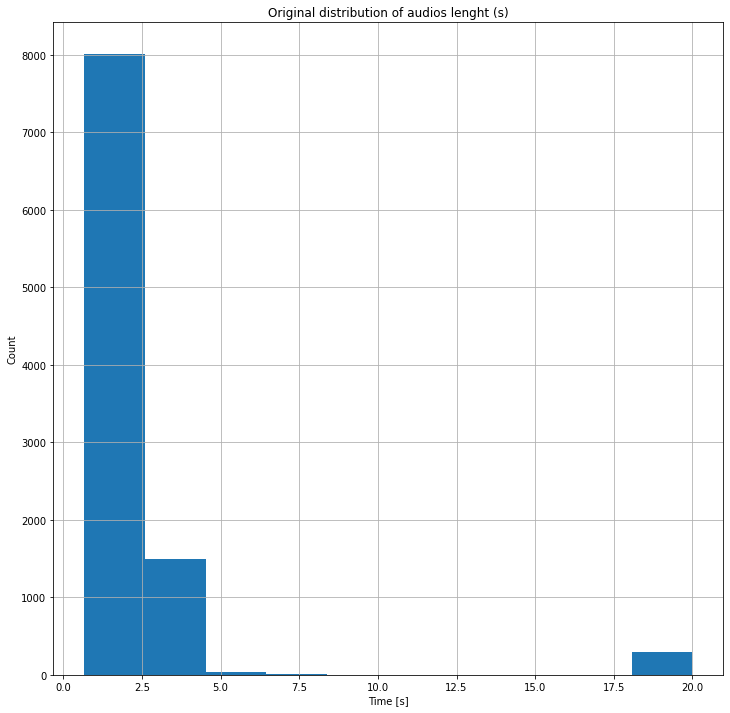

In [27]:
length_audios = []
length_audios_seconds = []
indexes = []
i = 0

for item in df_pd.audio:
    length_audios.append(len(item))
    length_audios_seconds.append(len(item)/sr)
#   Decomment if you are interested in retrieve indexes of audio within a specific range 
    # if len(item)/sr  >= 5 and len(item)/sr  <=7.5:
    #     indexes.append(i)
    i = i+1
        

length_audios=pd.Series(length_audios)
length_audios_seconds = pd.Series(length_audios_seconds)
#print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
plt.title("Original distribution of audios lenght (s)")
length_audios_seconds.hist()
plt.xlabel("Time [s]")
plt.ylabel("Count")
#print(length_audios_seconds)


In [28]:
#indexes

In [29]:
# See info of audios within specific range
#df_pd.iloc[indexes]

In [30]:
# index = 7123
# path_audio = df_development.path[index]
# path_working_directory+'/'+path_audio
# ipd.Audio(df_pd['audio'][7123], rate=22050)

### 2. Pre-Processing

According to several papers focused on audio classification, VDA is among one of the most preprocessing techinque adopted which aims to trim all the silence parts away from audio files.

To apply it, we will use _trim_ and _split_ librosa functions.

- _trim_: cut silence frames at the beginning and in the end of an audio file.
- _split_: saves the indexes (start, stop) of each non-silent frame in the audio file.

#### Trim

In [31]:
trim_audios = []
for i, audio in enumerate(df_pd.audio):
    audio_trim = librosa.effects.trim(audio, top_db=20)[0]
    trim_audios.append(audio_trim)
    
df_pd['audio_trim'] = trim_audios    
df_pd

,Id,audio,gender,ageRange,label,audio_trim
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic,"[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...
9849,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume,"[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9850,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights,"[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9851,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights,"[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9852,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights,"[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


Text(0, 0.5, 'Count')

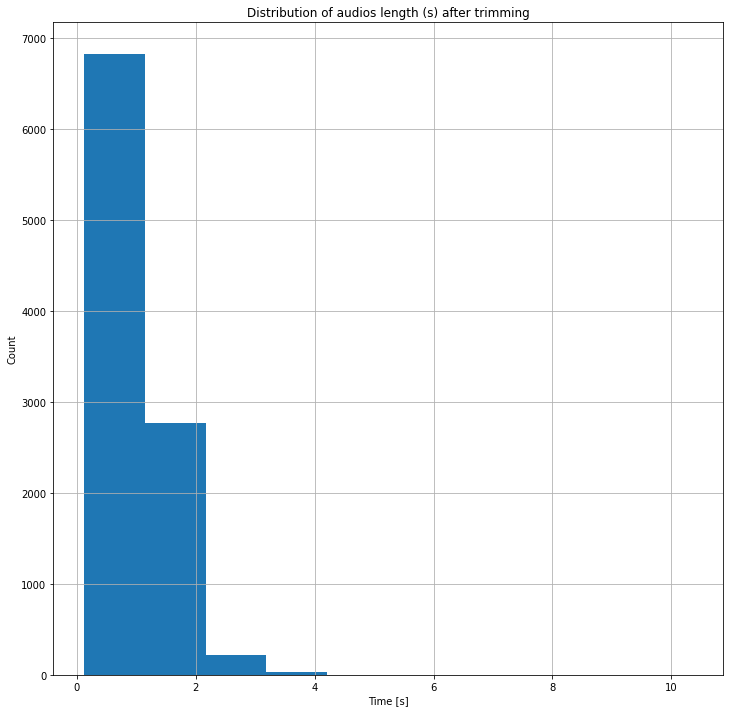

In [32]:
length_audios_trim = []
length_audios_seconds_trim = []
indexes = []
i = 0

for item in df_pd.audio_trim:
    length_audios_trim.append(len(item))
    length_audios_seconds_trim.append(len(item)/sr)
#   Decomment if you are interested in retrieve indexes of audio within a specific range 
    if len(item)/sr  > 4: # se 2.64 prestazioni minori
        indexes.append(i)
    i = i+1
        

length_audios_trim=pd.Series(length_audios_trim)
length_audios_seconds_trim = pd.Series(length_audios_seconds_trim)
#print(length_audios_seconds.value_counts())
plt.figure(figsize=(12,12))
plt.title("Distribution of audios length (s) after trimming")
length_audios_seconds_trim.hist()
plt.xlabel("Time [s]")
plt.ylabel("Count")
#print(length_audios_seconds)


In [33]:
# indexes

In [34]:
# idx = 8528
# print(len(df_pd['audio_trim'][idx]))
# ipd.Audio(df_pd['audio_trim'][idx], rate=22050)

In [35]:
df_pd=df_pd.drop(indexes).reset_index(drop=True) #reset_index because we have a new df and if we want to iterate over it is simpler
df_pd

,Id,audio,gender,ageRange,label,audio_trim
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic,"[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...
9843,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume,"[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9844,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights,"[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9845,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights,"[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9846,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights,"[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


#### Denoising

In [36]:
# audio = df_pd.audio[7]
# clean_audio=nr.reduce_noise(y=audio, sr=sr, n_std_thresh_stationary=1.5, stationary=True)

In [37]:
# ipd.Audio(audio, rate=22050)

In [38]:
# ipd.Audio(clean_audio, rate=22050)

In [39]:
# audios_cleaned = []

# for audio in df_pd.audio_trim:
    
#     audio_clean = nr.reduce_noise(y=audio, sr=sr, n_std_thresh_stationary=1.5, stationary=True)
#     audios_cleaned.append(audio_clean)
# #new_audio_reconstructed = np.hstack(audio_reconstructed)
# #s1 = df_pd['audio'][idx][non_silence_parts[1][0]:non_silence_parts[1][-1]]
# # s2 = df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[1][0]:librosa.effects.split(df_pd['audio'][3799])[1][-1]]

# #ipd.Audio(new_audio_reconstructed, rate=22050)

In [40]:
# df_pd['audio_cleaned'] = audios_cleaned    
# df_pd

#### Split

In [41]:
audios_reconstructed = []

for audio in df_pd.audio_trim:
    
    non_silence_parts = librosa.effects.split(audio, top_db=20)
    audio_reconstructed_parts = [] #save the non silent parts in a list that then will be merged together to obtain the reconstructed file
    
    for part in non_silence_parts:
        audio_reconstructed_parts.append(audio[part[0]:part[-1]])

    audio_reconstructed = np.hstack(audio_reconstructed_parts)
    audios_reconstructed.append(audio_reconstructed)
df_pd['audio_reconstructed'] = audios_reconstructed    
df_pd

,Id,audio,gender,ageRange,label,audio_trim,audio_reconstructed
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,change languagenone,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1....","[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,activatemusic,"[0.0005718688, 0.0005805124, 0.00058862584, 0....","[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[0.0076071513, 0.008677023, 0.009811347, 0.010...","[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...,...
9843,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",male,22-40,decreasevolume,"[-0.012367419, -0.01213057, -0.011735419, -0.0...","[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9844,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",male,22-40,deactivatelights,"[-0.00086439366, 0.011530005, 0.0026797082, -0...","[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9845,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",male,22-40,deactivatelights,"[0.0048560956, -3.8896687e-05, -0.00041252645,...","[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9846,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",male,22-40,deactivatelights,"[0.003923648, 0.0039615026, 0.0041058823, 0.00...","[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


#### Pre- emphasize

In [42]:
# emph_audios = []
# for i, audio in enumerate(df_pd.audio_trim):
#     audio_emph = librosa.effects.preemphasis(audio, return_zf=False)
#     emph_audios.append(audio_emph)
    
# df_pd['audio_emph'] = emph_audios    
# df_pd

In [43]:
df_pd.ageRange.value_counts()

22-40    7491
41-65    2115
65+       242
Name: ageRange, dtype: int64

### 3. Feature Extraction

Apply one hot encoding to categorical features.

In [44]:
categorical_features = ['gender', 'ageRange']

dummy_columns = categorical_features

for column in dummy_columns: 
    if column == 'ageRange':
      df_dummies = pd.get_dummies(df_pd[column], prefix = column, prefix_sep='=').drop('ageRange=65+', axis=1)#drop_first_true to avoid multi colinearity problem
    else:
      df_dummies = pd.get_dummies(df_pd[column], drop_first=True, prefix = column, prefix_sep='=') #drop_first_true to avoid multi colinearity problem
      
    df_pd = pd.concat([df_pd, df_dummies], axis = 1)


df_pd = df_pd.drop(columns=dummy_columns)
df_pd

,Id,audio,label,audio_trim,audio_reconstructed,gender=male,ageRange=22-40,ageRange=41-65
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1....","[-0.0010869442, 6.950152e-05, 0.0010575794, 1....",0,1,0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[0.0005718688, 0.0005805124, 0.00058862584, 0....","[0.0005718688, 0.0005805124, 0.00058862584, 0....",0,1,0
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...",0,1,0
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[0.0076071513, 0.008677023, 0.009811347, 0.010...","[0.0076071513, 0.008677023, 0.009811347, 0.010...",0,1,0
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...",0,1,0
...,...,...,...,...,...,...,...,...
9843,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",decreasevolume,"[-0.012367419, -0.01213057, -0.011735419, -0.0...","[-0.012367419, -0.01213057, -0.011735419, -0.0...",1,1,0
9844,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",deactivatelights,"[-0.00086439366, 0.011530005, 0.0026797082, -0...","[-0.00086439366, 0.011530005, 0.0026797082, -0...",1,1,0
9845,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",deactivatelights,"[0.0048560956, -3.8896687e-05, -0.00041252645,...","[0.0048560956, -3.8896687e-05, -0.00041252645,...",1,1,0
9846,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",deactivatelights,"[0.003923648, 0.0039615026, 0.0041058823, 0.00...","[0.003923648, 0.0039615026, 0.0041058823, 0.00...",1,1,0


#### Extracting MFCC features

First of all every audio should have the same length in order to get final coefficients for each audio of the same length.

**EDIT**: non mi serve più, perchè io sono ora interessato alla media, std, min, max, median dei coefficienti che sono sempre uguali (numero righe vecchia matrice) mentre il numero delle colonne cambia (tempo) però non è più importante quindi avere matrici tutte della stessa dimensione.

In [45]:
# Find maximum length of the audio in the dataframe
lengths = [len(audio) for audio in df_pd.audio_trim]
# idx = 45 #check
# lengths[idx], len(df_pd.audio.iloc[idx])
lengths = pd.Series(lengths)
#lengths.max() #88064
print(f"Max length: {lengths.max()}")
lengths[lengths == lengths.max()]
lengths.value_counts()[:10], lengths.max()

Max length: 88064


(20480    339
 19456    322
 18944    312
 18432    312
 17920    300
 17408    283
 20992    281
 19968    281
 16896    268
 16384    247
 dtype: int64, 88064)

In [46]:
88064/sr

3.9938321995464854

In [47]:
4*sr

88200

In [48]:
max_length = 4*sr

In [49]:
# ipd.Audio(df_pd['audio'][8136], rate=22050)

In [50]:
# len(df_pd['audio'][8136])

#### Padding

In [51]:
# # # Padding shorter audio with 0 samples in order to get all audio files of the same length
audios_reconstructed_padded = []
for i, audio in enumerate(df_pd.audio_reconstructed):
    audio_reconstructed_padded = np.pad(df_pd.audio_reconstructed[i],(0,max_length- len(df_pd.audio_reconstructed[i])),mode='constant', constant_values=0)
    audios_reconstructed_padded.append(audio_reconstructed_padded)

df_pd['audio_reconstructed_padded'] = audios_reconstructed_padded  
df_pd  

,Id,audio,label,audio_trim,audio_reconstructed,gender=male,ageRange=22-40,ageRange=41-65,audio_reconstructed_padded
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",change languagenone,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1....","[-0.0010869442, 6.950152e-05, 0.0010575794, 1....",0,1,0,"[-0.0010869442, 6.950152e-05, 0.0010575794, 1...."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",activatemusic,"[0.0005718688, 0.0005805124, 0.00058862584, 0....","[0.0005718688, 0.0005805124, 0.00058862584, 0....",0,1,0,"[0.0005718688, 0.0005805124, 0.00058862584, 0...."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",deactivatelights,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...","[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3...",0,1,0,"[3.145638e-05, 3.0807154e-05, 2.8492566e-05, 3..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[0.0076071513, 0.008677023, 0.009811347, 0.010...","[0.0076071513, 0.008677023, 0.009811347, 0.010...",0,1,0,"[0.0076071513, 0.008677023, 0.009811347, 0.010..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",increasevolume,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...","[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05...",0,1,0,"[4.5547e-06, 2.4867417e-05, 3.363467e-05, 3.05..."
...,...,...,...,...,...,...,...,...,...
9843,9849,"[0.009223618, 0.010777138, 0.009321626, 0.0099...",decreasevolume,"[-0.012367419, -0.01213057, -0.011735419, -0.0...","[-0.012367419, -0.01213057, -0.011735419, -0.0...",1,1,0,"[-0.012367419, -0.01213057, -0.011735419, -0.0..."
9844,9850,"[0.00936052, 0.010867924, 0.009305291, 0.00991...",deactivatelights,"[-0.00086439366, 0.011530005, 0.0026797082, -0...","[-0.00086439366, 0.011530005, 0.0026797082, -0...",1,1,0,"[-0.00086439366, 0.011530005, 0.0026797082, -0..."
9845,9851,"[0.0014334349, 0.001723074, 0.0015384919, 0.00...",deactivatelights,"[0.0048560956, -3.8896687e-05, -0.00041252645,...","[0.0048560956, -3.8896687e-05, -0.00041252645,...",1,1,0,"[0.0048560956, -3.8896687e-05, -0.00041252645,..."
9846,9852,"[0.009742705, 0.011407773, 0.009794228, 0.0103...",deactivatelights,"[0.003923648, 0.0039615026, 0.0041058823, 0.00...","[0.003923648, 0.0039615026, 0.0041058823, 0.00...",1,1,0,"[0.003923648, 0.0039615026, 0.0041058823, 0.00..."


In [52]:
len(df_pd.audio_reconstructed_padded[3])

88200

Plot any raw audio and its final trimmed, splitted and padded version

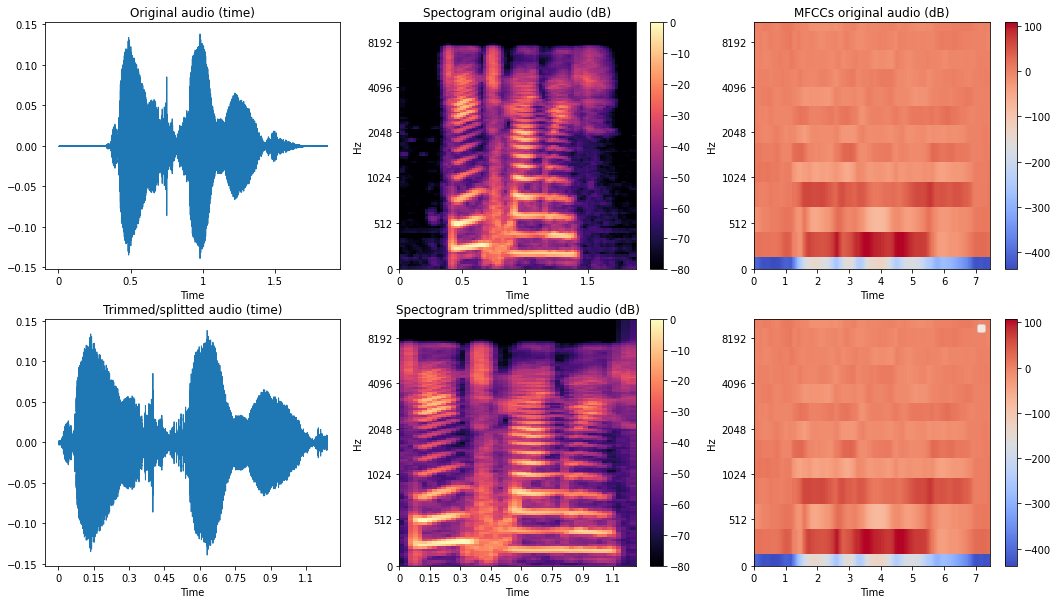

In [53]:
audio = df_pd.audio[0]
audio_trimmed_splitted = df_pd.audio_reconstructed[0]
audio_trimmed_splitted_padded = df_pd.audio_reconstructed_padded[0]

mel_features_audio = librosa.feature.melspectrogram(y=audio, sr=sr)
mel_features_audio_trimmed_splitted = librosa.feature.melspectrogram(y=audio_trimmed_splitted, sr=sr)
mfcc_audio  = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=2048, hop_length=128, n_mels = 40, dct_type=2)
mfcc_audio_trimmed_splitted = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=2048, hop_length=128, n_mels = 40, dct_type=2)
#mel_features_audio_trimmed_splitted_padded = librosa.feature.melspectrogram(y=audio_trimmed_splitted_padded, sr=sr)

S1 = librosa.power_to_db(mel_features_audio, ref=np.max)
S2 = librosa.power_to_db(mel_features_audio_trimmed_splitted, ref=np.max)
#S3 = librosa.power_to_db(mel_features_audio_trimmed_splitted_padded, ref=np.max)



fig, axs = plt.subplots(2,3, figsize=(18,10))
img_original = librosa.display.waveshow(audio,sr=sr, x_axis='time', label='original', ax=axs[0,0]);
img_trimmed_splitted = librosa.display.waveshow(audio_trimmed_splitted,sr=sr, x_axis='time', label='processed', ax=axs[1,0]);

#librosa.display.waveshow(audio_trimmed_splitted_padded,sr=sr, x_axis='time', label='processed', ax=axs[2,0]);

img_original_mel = librosa.display.specshow(S1, x_axis='time', y_axis='mel', ax=axs[0, 1]) # mfcc in row i, column 1
#plt.plot(np.linspace(0, len(mfcc_audio) / sample_rate, num=len(mfcc_audio)), audio)
#axs[0,2].imshow(mfcc_audio, aspect='auto', origin='lower', x_axis='time');
#img_original_mfcc = axs[0,2].imshow(mfcc_audio, interpolation='nearest', cmap='copper', origin='lower')
img_original_mfcc = librosa.display.specshow(mfcc_audio, x_axis='time',y_axis='mel',ax=axs[0,2])

img_trimmed_splitted_mel = librosa.display.specshow(S2, x_axis='time', y_axis='mel', ax=axs[1, 1]) # mfcc in row i, column 1
img_trimmed_splitted_mfcc = librosa.display.specshow(mfcc_audio_trimmed_splitted, x_axis='time',y_axis='mel', ax=axs[1,2])

#librosa.display.specshow(S3, x_axis='time', y_axis='mel',ax=axs[2, 1]) # mfcc in row i, column 1


axs[0,0].set(title="Original audio (time)")
axs[0,1].set(title="Spectogram original audio (dB)")
axs[0,2].set(title="MFCCs original audio (dB)")


axs[1,0].set(title="Trimmed/splitted audio (time)")
axs[1,1].set(title="Spectogram trimmed/splitted audio (dB)")
#axs[2,0].set(title="Trimmed/splitted audio (time)")


# axs[w,0].set(title="Trimmed/splitted audio (time)")
# axs[1,1].set(title="Spectogram trimmed/splitted audio (dB)")

fig.colorbar(img_original_mel, ax=[axs[0,1]])
fig.colorbar(img_original_mfcc, ax=[axs[0,2]])
fig.colorbar(img_trimmed_splitted_mel, ax=[axs[1,1]])
fig.colorbar(img_trimmed_splitted_mfcc, ax=[axs[1,2]])

# axs[2,0].set(title="Padded audio (time)")
# axs[2,1].set(title="Spectogram padded audio (dB)")
plt.legend()

# #librosa.display.specshow(mfccs, x_axis='time', ax=ax[i, 1]) # mfcc in row i, column 1

# axs[0, 0].librosa.display.waveshow(s1,sr=sr, x_axis='time', label='original');
# axs[0, 0].set_title('Original audio')
# axs[0, 1].librosa.display.specshow(S1, x_axis='time', y_axis='mel');
# axs[0, 1].set_title('Spectogram orignal audio')
# axs[1, 0].librosa.display.waveshow(s2,sr=sr, x_axis='time', label='processed');
# axs[1, 0].set_title('Processed audio')
# axs[1, 1].librosa.display.specshow(S2, x_axis='time', y_axis='mel');
# axs[1, 1].set_title('Spectogram processed audio')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [54]:
# idx = 0
# ipd.Audio(s1[:15434], rate=22050)

In [55]:
# n_windows = 20
# n_samples_window = len(audio_trimmed_splitted_padded)//n_windows
# n_samples_window, 4410//4

In [56]:
# mfccs = []
# mfccs_spectograms = []
# svm = True
# categorical_features = ["gender=male", 'ageRange=41-65', 'ageRange=65+']
# audio_reconstructed_padded = np.array(df_pd.audio_reconstructed_padded)
# for first_sample_window in range(0, max_length, n_samples_window):
#   final_sample_window = first_sample_window + n_samples_window
#   #print(first_sample_window, final_sample_window)
#   #print(len(df_pd.audio_reconstructed[first_sample_window:final_sample_window]))
#   #break
#   mfcc_window =  librosa.feature.mfcc(y=audio_reconstructed_padded[0][first_sample_window:final_sample_window], 
#                               sr=sr, 
#                               n_mfcc=13,
#                             dct_type=2)
#   mfccs_spectograms.append(mfcc_window)
  
#   # mfcc_means = mfcc_window.mean(axis=1)
#   # mfcc_medians = np.median(mfcc_window, axis=1)
#   # mfcc_stds = mfcc_window.std(axis=1)
#   # mfcc_maxs = mfcc_window.max(axis=1)
#   # mfcc_mins = mfcc_window.min(axis=1)

#   #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
#   #audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)
  
#   #FLATTEN MFCC MATRIX
#   mfccs.append(mfcc_window.flatten())


In [57]:
# df_single_window = pd.DataFrame(mfccs)
# df_single_window

In [58]:
# librosa.display.specshow(mfccs_spectograms[5], y_axis='mel',x_axis='time') # mfcc in row i, column 1


In [59]:
# mfccs_spectograms[5].shape

In [60]:
# mfccs_spectograms[5].mean(axis=1)

In [61]:
# mfcc_0 = librosa.feature.mfcc(y=df_pd.audio[0], 
#                               sr=sr, 
#                               n_mfcc=13)
# plt.figure()
# librosa.display.waveshow(df_pd.audio[0],sr=sr, x_axis='time', label='original');
# plt.figure()
# librosa.display.specshow(mfcc_0, y_axis='mel',x_axis='time') # mfcc in row i, column 1


In [62]:
# df_single_window = pd.DataFrame(mfccs)
# df_single_window

In [63]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_single_window = pd.DataFrame(mfccs)
# if svm == True:
#   scaled_numerical_df = scaler.fit_transform(df_single_window)
#   scaled_numerical_df = pd.DataFrame(scaled_numerical_df)
# else:
#     scaled_numerical_df = pd.DataFrame(mfccs)


# X = pd.concat([df_pd[categorical_features], scaled_numerical_df], axis=1)
# y = df_pd["label"]

In [64]:
seed = 42

In [65]:
### RandomForest Classifier ###
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def randforest_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_RF= RandomForestClassifier(random_state =seed)

    parameters = {'n_estimators':[100, 150, 200], 
                  'criterion':['gini', 'entropy'],
                  'max_features':['sqrt', 'log2']}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_RF = GridSearchCV(estimator=model_RF,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_RF.fit(input_x, input_y)
    best_parameters_RF = grid_search_RF.best_params_  
    best_score_RF = grid_search_RF.best_score_ 
    print(best_parameters_RF)
    print(best_score_RF)
    results = grid_search_RF.cv_results_
    
    return best_parameters_RF, results, best_score_RF



In [66]:
### RandomForest Classifier ###
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def svm_classifier(input_x, input_y, cv=10, seed = seed):
    ## Defining parameters
    model_SVM= SVC(random_state =seed)

    parameters = {'kernel':  ['rbf'], 
                   "C" : [11, 12, 13, 14],
                  "gamma" : ['auto']
                  }

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_SVM = GridSearchCV(estimator=model_SVM,  
                         param_grid=parameters,
                         scoring='accuracy',
                         cv=cv,
                         n_jobs=-1,
                        verbose = 15)

    ## Lastly, finding the best parameters.

    grid_search_SVM.fit(input_x, input_y)
    best_parameters = grid_search_SVM.best_params_  
    best_score = grid_search_SVM.best_score_ 
    print(best_parameters)
    print(best_score)
    results = grid_search_SVM.cv_results_
    
    return model_SVM, best_parameters, results, best_score



In [67]:
import warnings
warnings.filterwarnings("ignore")

In [68]:
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features = []
hop_length = 128
frame_rate = sr*2/hop_length

n_ffts = [512, 1024, 2048, 4096, 8192]
hops = [64, 128, 256, 512, 1024, 2048, 4096]

categorical_features = ["gender=male", 'ageRange=22-40', 'ageRange=41-65']

svm = True


features = []
for i, audio in enumerate(df_pd.audio_reconstructed):
#n_fft = int(frame_rate*len(audio))
#For each trim audio extract MFCC (so we will get a matrix of n_mfcc components*nc, with nc variable)
    mfcc_features = librosa.feature.mfcc(y=audio, 
                              sr=sr*2, 
                              n_mfcc=13,
                              lifter = 0, 
                              n_fft=2048, 
                              hop_length=128,
                              n_mels = 40,
                              center=True,
                            dct_type=2)
#    mfcc_features = sklearn.preprocessing.scale(mfcc_features, axis=1)
#   mel_features = librosa.feature.melspectrogram(y=df_pd.audio_trim[i], sr=sr)
#   spectogram = librosa.power_to_db(mel_features, ref=np.max)

#For each coefficient we compute the mean, median, std, max, min so we will have a total of n_mfcc*5 features for each audio
    mfcc_means = mfcc_features.mean(axis=1)
    mfcc_medians = np.median(mfcc_features, axis=1)
    mfcc_stds = mfcc_features.std(axis=1)
    mfcc_maxs = mfcc_features.max(axis=1)
    mfcc_mins = mfcc_features.min(axis=1)

    #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
    audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)

    features.append(audio_features)
    #adjust spectogram size to get nice number of columns that are easy to divide3
    #spectogram= np.hstack((spectogram,tmp))

    #spectograms.append(spectogram)
    
new_df = pd.DataFrame(features)
if svm == True:
  scaled_numerical_df = scaler.fit_transform(new_df)
  scaled_numerical_df = pd.DataFrame(scaled_numerical_df)
else:
    scaled_numerical_df = pd.DataFrame(features)

X = scaled_numerical_df
#X = pd.concat([df_pd[categorical_features], scaled_numerical_df], axis=1)
y = df_pd["label"]

if i == 0:
  print(X.shape, y.shape)

# new_df['gender=male'] = df_pd["gender=male"]
# new_df['ageRange=41-65'] = df_pd["ageRange=41-65"]
# new_df['ageRange=65+'] = df_pd["ageRange=65+"]
# new_df['label'] = df_pd["label"]

# y = new_df['label']
# X = new_df.drop(columns='label')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# if svm == True: #standardize
#   X_train_scaled = scaler.fit_transform(X_train)
#   X_test_scaled = scaler.transform(X_test)

print("###########################################################")
print("DATASET SHAPE")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("")

# print(f"HYPERPARAMS: n_fft = {n_fft}, hop = {hop}")
# print("")

best_model_SVM, _, _, best_score = svm_classifier(X_train, y_train, 10, seed)
print("")
print(f"BEST RESULT: {best_score}")
print("")
            
            

###########################################################
DATASET SHAPE
(7878, 65) (1970, 65) (7878,) (1970,)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'C': 11, 'gamma': 'auto', 'kernel': 'rbf'}
0.6506699927115114

BEST RESULT: 0.6506699927115114



In [69]:
best_model_SVM = SVC(random_state=seed, C=11, gamma='auto', kernel='rbf') 
best_model_SVM.fit(X_train, y_train)
y_pred = best_model_SVM.predict(X_test)

In [70]:
y_pred[0]

'increaseheat'

In [71]:
from sklearn.metrics import accuracy_score
print(f"Test accuracy: {accuracy_score(y_pred, y_test)}")

Test accuracy: 0.6593908629441624


In [72]:
y_pred

array(['increaseheat', 'deactivatelights', 'increasevolume', ...,
       'decreasevolume', 'decreaseheat', 'decreaseheat'], dtype=object)

### Testing on Evaluation set

In [73]:
colab = True

if colab == True:
  path= r'/content/evaluation.csv'
else:
  path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/development.csv'

df_evaluation = pd.read_csv(path)
df_evaluation

,Id,path,speakerId,Self-reported fluency level,First Language spoken,Current language used for work/school,gender,ageRange
0,0,dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53c...,NgQEvO2x7Vh3xy2xz,native,English (United States),English (United States),male,22-40
1,1,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f8...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
2,2,dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d5...,7B4XmNppyrCK977p,native,English (United States),English (United States),male,41-65
3,3,dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3...,k5bqyxx2lzIbrlg9,native,English (United States),English (United States),male,22-40
4,4,dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a...,V4ZbwLm9G5irobWn,native,English (United States),English (United States),female,41-65
...,...,...,...,...,...,...,...,...
1450,1450,dsl_data/audio/speakers/oOK5kxoW7dskMbaK/02f5d...,oOK5kxoW7dskMbaK,native,English (United States),English (United States),female,22-40
1451,1451,dsl_data/audio/speakers/oOK5kxoW7dskMbaK/87191...,oOK5kxoW7dskMbaK,native,English (United States),English (United States),female,22-40
1452,1452,dsl_data/audio/speakers/ppymZZDb2Bf4NQnE/f2a9e...,ppymZZDb2Bf4NQnE,native,English (United States),English (United States),female,41-65
1453,1453,dsl_data/audio/speakers/aokxBz9LxXHzZzay/f347b...,aokxBz9LxXHzZzay,native,English (United States),English (United States),female,22-40


In [74]:
if colab == True:
  path_working_directory= r'/content/drive/MyDrive/'
else:
  path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
paths_recordings = df_evaluation['path']

In [75]:
signals = []
ids = []
genders = []
ageRanges = []

for i, row in df_evaluation.iterrows():
    path = row['path']
    gender = row['gender']
    ageRange = row['ageRange']

    file_path = f'{path_working_directory}/{path}'
    print(file_path)
    signal, sr = librosa.load(file_path)

    ids.append(i)
    signals.append(signal)
    genders.append(gender)
    ageRanges.append(ageRange)



# for path in paths_recordings_dev:
#     file_path = f'{path_to_load_dev}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)


/content/drive/MyDrive//dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/f53ce6b0-45bf-11e9-8ec0-7bf21d1cfe30.wav
/content/drive/MyDrive//dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/1d5f80b0-4527-11e9-a843-8db76f4b5e29.wav
/content/drive/MyDrive//dsl_data/audio/speakers/7B4XmNppyrCK977p/1c0d59c0-45cd-11e9-9992-dfba019cb646.wav
/content/drive/MyDrive//dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/275c3960-4526-11e9-a843-8db76f4b5e29.wav
/content/drive/MyDrive//dsl_data/audio/speakers/V4ZbwLm9G5irobWn/b7c7a180-4529-11e9-a843-8db76f4b5e29.wav
/content/drive/MyDrive//dsl_data/audio/speakers/k5bqyxx2lzIbrlg9/8d017750-4529-11e9-a843-8db76f4b5e29.wav
/content/drive/MyDrive//dsl_data/audio/speakers/V4ejqNL4xbUKkYrV/f8769fa0-4598-11e9-bf4b-216bfa333ac2.wav
/content/drive/MyDrive//dsl_data/audio/speakers/NgQEvO2x7Vh3xy2xz/628b69b0-45bd-11e9-8ec0-7bf21d1cfe30.wav
/content/drive/MyDrive//dsl_data/audio/speakers/4BrX8aDqK2cLZRYl/ec446bf0-452e-11e9-b1e4-e5985dca719e.wav
/content/drive/MyDrive//dsl_data/audio/speak

In [76]:
df_pd_eval = pd.DataFrame()
df_pd_eval['Id'] = ids
df_pd_eval['audio'] = signals
df_pd_eval['gender'] = genders
df_pd_eval['ageRange'] = ageRanges
df_pd_eval

# df.append(path_recording_eval)
# df_eval.append(signals)
# df_eval.append(sample_rates)
# #df_eval.append(labels)

,Id,audio,gender,ageRange
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65
...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40


In [77]:
path_working_directory

'/content/drive/MyDrive/'

In [78]:
name_file = r'/df_pd_eval.pickle'
print( path_working_directory+name_file)
with open(path_working_directory+name_file, "wb") as output_file:
    pickle.dump(df_pd_eval, output_file)

/content/drive/MyDrive//df_pd_eval.pickle


In [ ]:
# if colab == True:
#   path_working_directory= r'/content/drive/MyDrive/'
# else:
#   path_working_directory = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23'
# paths_recordings = df_evaluation['path']

In [ ]:
# signals = []
# sample_rates = []

# for path in paths_recordings:
#     file_path = f'{path_working_directory}/{path}'
    
#     signal, sr = librosa.load(file_path)
    
#     signals.append(signal)
#     sample_rates.append(sr)

In [ ]:
# df_eval = []
# df_eval.append(paths_recordings)
# df_eval.append(signals)
# df_eval.append(sample_rates)
# #df_eval.append(labels)

In [80]:
name_file = r'/df_pd_eval.pickle'

with open(path_working_directory+name_file, 'rb') as f:
        df_pd_eval = pickle.load(f)
df_pd_eval

,Id,audio,gender,ageRange
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65
...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40


In [83]:
trim_audios = []
for i, audio in enumerate(df_pd_eval.audio):
    audio_trim = librosa.effects.trim(audio, top_db=20)[0]
    trim_audios.append(audio_trim)
    
df_pd_eval['audio_trim'] = trim_audios    
df_pd_eval

,Id,audio,gender,ageRange,audio_trim
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-9.9547375e-05, -9.787871e-05, -6.138714e-05,..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-0.007584546, 0.016109811, 0.04742192, 0.0286..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65,"[-0.011286507, -0.01852172, -0.013579795, -0.0..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-0.00033873884, -0.0003030687, -0.00023324917..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.00012774397, -0.00023200853, 0.00034565205..."
...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[0.00013520455, 0.00038343164, 0.00084033713, ..."
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.034197435, -0.019847801, -0.010831601, -0...."
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.0036772517, 0.0010779247, 0.00663003, 0.00..."
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.0018606808, -0.002219212, -0.002400794, -0..."


In [84]:
audios_reconstructed = []

for audio in df_pd_eval.audio_trim:
    
    non_silence_parts = librosa.effects.split(audio, top_db=20)
    audio_reconstructed_parts = [] #save the non silent parts in a list that then will be merged together to obtain the reconstructed file
    
    for part in non_silence_parts:
        audio_reconstructed_parts.append(audio[part[0]:part[-1]])

    audio_reconstructed = np.hstack(audio_reconstructed_parts)
    audios_reconstructed.append(audio_reconstructed)

df_pd_eval['audio_reconstructed'] = audios_reconstructed    
df_pd_eval

,Id,audio,gender,ageRange,audio_trim,audio_reconstructed
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,..."
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-0.007584546, 0.016109811, 0.04742192, 0.0286...","[-0.007584546, 0.016109811, 0.04742192, 0.0286..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,41-65,"[-0.011286507, -0.01852172, -0.013579795, -0.0...","[-0.011286507, -0.01852172, -0.013579795, -0.0..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",male,22-40,"[-0.00033873884, -0.0003030687, -0.00023324917...","[-0.00033873884, -0.0003030687, -0.00023324917..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.00012774397, -0.00023200853, 0.00034565205...","[-0.00012774397, -0.00023200853, 0.00034565205..."
...,...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ..."
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.034197435, -0.019847801, -0.010831601, -0....","[-0.034197435, -0.019847801, -0.010831601, -0...."
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,41-65,"[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00..."
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",female,22-40,"[-0.0018606808, -0.002219212, -0.002400794, -0...","[-0.0018606808, -0.002219212, -0.002400794, -0..."


In [85]:
categorical_features = ['gender', 'ageRange']

dummy_columns = categorical_features

for column in dummy_columns: 
    if column == 'ageRange':
      df_dummies = pd.get_dummies(df_pd_eval[column], prefix = column, prefix_sep='=')#drop_first_true to avoid multi colinearity problem
    else:
      df_dummies = pd.get_dummies(df_pd_eval[column], drop_first=True, prefix = column, prefix_sep='=') #drop_first_true to avoid multi colinearity problem

    df_pd_eval = pd.concat([df_pd_eval, df_dummies], axis = 1)


df_pd_eval = df_pd_eval.drop(columns=dummy_columns)
df_pd_eval

,Id,audio,audio_trim,audio_reconstructed,gender=male,ageRange=22-40,ageRange=41-65
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...","[-9.9547375e-05, -9.787871e-05, -6.138714e-05,...",1,1,0
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.007584546, 0.016109811, 0.04742192, 0.0286...","[-0.007584546, 0.016109811, 0.04742192, 0.0286...",1,1,0
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.011286507, -0.01852172, -0.013579795, -0.0...","[-0.011286507, -0.01852172, -0.013579795, -0.0...",1,0,1
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00033873884, -0.0003030687, -0.00023324917...","[-0.00033873884, -0.0003030687, -0.00023324917...",1,1,0
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00012774397, -0.00023200853, 0.00034565205...","[-0.00012774397, -0.00023200853, 0.00034565205...",0,0,1
...,...,...,...,...,...,...,...
1450,1450,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.00013520455, 0.00038343164, 0.00084033713, ...","[0.00013520455, 0.00038343164, 0.00084033713, ...",0,1,0
1451,1451,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.034197435, -0.019847801, -0.010831601, -0....","[-0.034197435, -0.019847801, -0.010831601, -0....",0,1,0
1452,1452,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00...","[-0.0036772517, 0.0010779247, 0.00663003, 0.00...",0,0,1
1453,1453,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.0018606808, -0.002219212, -0.002400794, -0...","[-0.0018606808, -0.002219212, -0.002400794, -0...",0,1,0


In [86]:
seed = 42

In [87]:
features =[]
categorical_features_ohe = ['gender=male', 'ageRange=22-40','ageRange=41-65']

for i, audio in enumerate(df_pd_eval.audio_reconstructed):
#n_fft = int(frame_rate*len(audio))
#For each trim audio extract MFCC (so we will get a matrix of n_mfcc components*nc, with nc variable)
    mfcc_features = librosa.feature.mfcc(y=audio, 
                              sr=sr*2, 
                              n_mfcc=13,
                              lifter = 10, 
                              n_fft=2048, 
                              hop_length=128,
                              n_mels = 40,
                            dct_type=2)
#    mfcc_features = sklearn.preprocessing.scale(mfcc_features, axis=1)
#   mel_features = librosa.feature.melspectrogram(y=df_pd.audio_trim[i], sr=sr)
#   spectogram = librosa.power_to_db(mel_features, ref=np.max)

#For each coefficient we compute the mean, median, std, max, min so we will have a total of n_mfcc*5 features for each audio
    mfcc_means = mfcc_features.mean(axis=1)
    mfcc_medians = np.median(mfcc_features, axis=1)
    mfcc_stds = mfcc_features.std(axis=1)
    mfcc_maxs = mfcc_features.max(axis=1)
    mfcc_mins = mfcc_features.min(axis=1)

    #we stack together the means, stds, medians, maxs and mins to get the final feature vector for each audio.
    audio_features = list(mfcc_means)+list(mfcc_medians)+list(mfcc_stds)+list(mfcc_maxs)+list(mfcc_mins)

    features.append(audio_features)
    #adjust spectogram size to get nice number of columns that are easy to divide3
    #spectogram= np.hstack((spectogram,tmp))

    #spectograms.append(spectogram)
    
new_df = pd.DataFrame(features)
if svm == True:
  scaled_numerical_df = scaler.fit_transform(new_df)
  scaled_numerical_df = pd.DataFrame(scaled_numerical_df)
else:
    scaled_numerical_df = pd.DataFrame(features)


X = pd.concat([df_pd_eval[categorical_features_ohe], scaled_numerical_df], axis=1)
X

,gender=male,ageRange=22-40,ageRange=41-65,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,64
0,1,1,0,-1.485106,2.464284,2.414523,-1.004903,1.902155,-0.490553,1.412457,...,-0.772507,2.093662,-0.740114,0.522977,-0.215241,0.731908,1.236604,-0.862082,0.133485,-0.671209
1,1,1,0,0.192875,-0.395300,1.659455,0.476058,-1.416920,-1.056214,-1.273151,...,0.605767,-0.904821,-0.311609,-1.035330,-0.072321,-0.922826,-0.811469,-1.318554,0.391631,0.132285
2,1,0,1,-0.962237,0.635058,-1.759880,0.710134,0.920477,-1.524720,1.146858,...,0.764379,0.376461,-0.961639,0.225116,-0.655877,0.903573,0.336571,0.050937,-0.024776,1.472612
3,1,1,0,-0.259701,-0.347329,0.790584,-1.961176,-2.043538,0.771136,-0.788736,...,-1.218643,-0.655445,0.142921,-0.660722,0.931742,-0.371628,0.385064,0.628549,0.853008,-0.173197
4,0,0,1,0.663651,-0.688477,-0.687730,0.859122,-0.903456,0.004715,-0.344537,...,-0.759986,-1.535555,-0.188313,-0.032835,0.343421,0.055134,-0.479051,0.064074,0.195676,-0.674993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,0,1,0,0.150130,0.016894,0.667981,-0.556879,-0.607777,0.398392,-0.024453,...,-0.862550,-0.197226,0.142773,-0.441028,0.585832,0.023144,0.874711,0.658976,-0.849012,0.276816
1451,0,1,0,0.480406,0.720328,0.134480,-1.258965,-0.010343,0.776091,-0.522386,...,-0.595807,0.173217,1.074135,-0.741055,0.443487,0.052796,-0.685945,0.914377,1.400147,-2.228459
1452,0,0,1,1.585234,-1.317517,-1.392582,0.470722,-1.402080,1.012200,-0.041389,...,1.171786,-1.096666,0.996054,1.327297,0.708464,0.641467,1.390138,2.340463,0.415010,0.731193
1453,0,1,0,-0.267421,-0.426561,-0.287182,0.347426,-0.668373,-1.972826,0.278290,...,0.074022,-1.930993,-1.740457,0.481256,-0.670076,-1.760247,-0.760761,0.415144,-0.337565,-0.435752


In [89]:
scaled_numerical_df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-1.485106,2.464284,2.414523,-1.004903,1.902155,-0.490553,1.412457,0.023641,1.233846,1.246848,...,-0.772507,2.093662,-0.740114,0.522977,-0.215241,0.731908,1.236604,-0.862082,0.133485,-0.671209
1,0.192875,-0.395300,1.659455,0.476058,-1.416920,-1.056214,-1.273151,0.591886,-1.212048,-1.730065,...,0.605767,-0.904821,-0.311609,-1.035330,-0.072321,-0.922826,-0.811469,-1.318554,0.391631,0.132285
2,-0.962237,0.635058,-1.759880,0.710134,0.920477,-1.524720,1.146858,-1.932796,1.091726,0.487784,...,0.764379,0.376461,-0.961639,0.225116,-0.655877,0.903573,0.336571,0.050937,-0.024776,1.472612
3,-0.259701,-0.347329,0.790584,-1.961176,-2.043538,0.771136,-0.788736,0.902944,-0.663315,-0.422662,...,-1.218643,-0.655445,0.142921,-0.660722,0.931742,-0.371628,0.385064,0.628549,0.853008,-0.173197
4,0.663651,-0.688477,-0.687730,0.859122,-0.903456,0.004715,-0.344537,0.301951,0.343787,-0.681213,...,-0.759986,-1.535555,-0.188313,-0.032835,0.343421,0.055134,-0.479051,0.064074,0.195676,-0.674993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,0.150130,0.016894,0.667981,-0.556879,-0.607777,0.398392,-0.024453,1.224468,-0.183112,0.828168,...,-0.862550,-0.197226,0.142773,-0.441028,0.585832,0.023144,0.874711,0.658976,-0.849012,0.276816
1451,0.480406,0.720328,0.134480,-1.258965,-0.010343,0.776091,-0.522386,0.155885,0.206569,-0.285860,...,-0.595807,0.173217,1.074135,-0.741055,0.443487,0.052796,-0.685945,0.914377,1.400147,-2.228459
1452,1.585234,-1.317517,-1.392582,0.470722,-1.402080,1.012200,-0.041389,0.537574,-0.048664,0.327963,...,1.171786,-1.096666,0.996054,1.327297,0.708464,0.641467,1.390138,2.340463,0.415010,0.731193
1453,-0.267421,-0.426561,-0.287182,0.347426,-0.668373,-1.972826,0.278290,-0.314680,-0.944577,-0.860865,...,0.074022,-1.930993,-1.740457,0.481256,-0.670076,-1.760247,-0.760761,0.415144,-0.337565,-0.435752


Use the model with best configuration

In [90]:
# #best_model_SVM = SVC(C=12, gamma='auto', kernel='rbf') 
y_pred = best_model_SVM.predict(scaled_numerical_df)

In [92]:
submission_df = pd.DataFrame()
submission_df['Id'] = df_evaluation['Id']
submission_df['Predicted'] = y_pred
submission_df

,Id,Predicted
0,0,decreaseheat
1,1,decreaseheat
2,2,change languagenone
3,3,deactivatelights
4,4,increaseheat
...,...,...
1450,1450,change languagenone
1451,1451,decreasevolume
1452,1452,increaseheat
1453,1453,decreaseheat


In [95]:
path_sub = r'/content/submission.csv'
submission_df.to_csv(path_sub, index=False)

In [ ]:
# list(y_pred)

In [ ]:
# colab = True

# if colab == True:
#   path= r'/content/sample_submission.csv'
# else:
#   path = r'C:/Users/andre/OneDrive/Documenti/GitHub/winter_exam_22_23/sample_submission.csv'

# df_submission = pd.read_csv(path)
# df_submission

In [ ]:
# y_pred

1 : increase volume

2: increase heat

3: decrease volume

4: decrease heat

5: change language

6: activate music

7: deactivate lights

In [ ]:
# mapping = {1: 'increasevolume', 2:'increaseheat', 3:'decreaseheat', 4:'decreaseheat', 5:'change languagenone', 6:'activatemusic', 7:'deactivatelights'}

In [ ]:
# df_submission['Predicted'] = np.nan*len(y_pred)
# y_pred = pd.Series(y_pred).map(mapping)
# df_submission['Predicted'] = y_pred

# df_submission

In [ ]:
# path_sub= r'/content/submission.csv'
# df_submission.to_csv(path_sub, index=False)

In [ ]:
#Test

# index = 1
# mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[index], sr=sr)
# print(mfcc_features.shape)

# medians = np.median(mfcc_features, axis=1)
# print(medians.shape)

# means = mfcc_features.mean(axis=1)
# medians = np.median(mfcc_features, axis=1)
# stds = mfcc_features.std(axis=1)
# maxs = mfcc_features.max(axis=1)
# mins = mfcc_features.min(axis=1)
# mins

In [ ]:
# #Add one hot encoding features and label column
# new_df['gender=male'] = df_pd["gender=male"]
# new_df['ageRange=41-65'] = df_pd["ageRange=41-65"]
# new_df['ageRange=65+'] = df_pd["ageRange=65+"]
# new_df['label'] = df_pd["label"]

In [ ]:
# new_df

In [ ]:
# indexes

In [ ]:
# name_file = r'/df.pickle'

# with open(path_working_directory+name_file, 'rb') as f:
#         df = pickle.load(f)
# df_tmp = pd.DataFrame({'audio':df[1], 'gender': df_development.gender, 'ageRange': df_development.ageRange, 'label':df[3]})
# #df_pd[9840:9845] ETICHETTATO COME FEMALE MA SECONDO ME E MALE
# pd.DataFrame(df_tmp).iloc[23:28]

In [ ]:
# df_pd.iloc[23:28]

In [ ]:
# df_tmp['audio'][26]

In [ ]:
# df_tmp['audio'][24] == df_pd['audio'][24]

### 4. Training and Validation

In [ ]:
# y = new_df['label']
# X = new_df.drop(columns='label')
# seed = 42

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape 

In [ ]:
# ### RandomForest Classifier ###
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# def randforest_classifier(input_x, input_y, cv=10, seed = seed):
#     ## Defining parameters
#     model_RF= RandomForestClassifier(random_state =seed)

#     parameters = {'n_estimators':[100], 
#                   'criterion':['gini', 'entropy'],
#                   'max_features':['sqrt', 'log2']}

#     ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

#     grid_search_RF = GridSearchCV(estimator=model_RF,  
#                          param_grid=parameters,
#                          scoring='accuracy',
#                          cv=cv,
#                          n_jobs=-1,
#                         verbose = 15)

#     ## Lastly, finding the best parameters.

#     grid_search_RF.fit(input_x, input_y)
#     best_parameters_RF = grid_search_RF.best_params_  
#     best_score_RF = grid_search_RF.best_score_ 
#     print(best_parameters_RF)
#     print(best_score_RF)
#     results = grid_search_RF.cv_results_
    
#     return best_parameters_RF, results

# best_params, RF_CV_results = randforest_classifier(X_train, y_train, 10, seed)

In [ ]:
# rf = RandomForestClassifier(n_estimators=50,criterion='entropy', max_features="sqrt", random_state =seed)
# rf.fit(X_train, y_train)

In [ ]:
# feature_names = [f"{f}" for f in X_train.columns]
# print(feature_names)
# importances=rf.feature_importances_
# forest_importances=  pd.Series(importances, index=feature_names).sort_values(ascending=False)
# print("means: 0-12")
# print("medians: 13-25")
# print("stds: 26-38")
# print("max: 39-51")
# print("min: 52-64")
# plt.figure(figsize=(12,12))
# forest_importances.plot.bar()
# plt.title("Feature importances using MDI")
# plt.ylabel("Mean decrease in impurity")


100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=1024): 0.5019027470507421

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=2048, hop_length=256): 0.5107861570314567

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=2048, hop_length=128) = 0.5144707138203936

100 alberi   mfcc_features = librosa.feature.mfcc(y=df_pd.audio_emph[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128) = 0.5152318126406905

100 alberi mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128): 0.520815407736118

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_trim[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128, n_mels = 90): 0.523992189062107

100 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr, n_mfcc=13, n_fft=4096, hop_length=128, n_mels = 90): 0.5242471249169564

100 alberi,   mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, n_fft=4096, hop_length=128, n_mels = 90): 0.5308446584407794

200 alberi, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=128, n_mels = 90): 0.538330839337199

100, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=128, n_mels = 90, dct_type=1) = 0.5279249092163907

100, mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i],  sr=sr*2, n_mfcc=13,lifter = 10,  n_fft=4096, hop_length=128, n_mels = 90, dct_type=3): 0.5046902714800793

**BEST**: 100 alberi,  tagliando trim audios > 1 sec mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=64, n_mels = 90, dct_type=2): **0.5398856887280141**

100 alberi,  tagliando trim audios > 2 sec mfcc_features = librosa.feature.mfcc(y=df_pd.audio_reconstructed[i], sr=sr*2, n_mfcc=13, lifter = 10, n_fft=4096, hop_length=64, n_mels = 90, dct_type=2): **0.5274044795783926**








In [ ]:
# new_df

In [ ]:
# new_df['ageRange=41-65']

In [ ]:
# df_pd['label'][7167]

We noticed that some audios (ex. index = 7167) are kept because there noise (no silence) and trim is not able to erase it away, so now we apply noise reduction.

Let's listent the audio.

In [ ]:
# # 7167 : rumore finale che non toglie
# index = 7167
# s1 = df_pd['audio'][index]
# ipd.Audio(df_pd['audio'][index], rate=22050)
# plt.figure()
# plt.plot(s1)

In [ ]:
# # Original audio
# ipd.Audio(s1, rate=22050)

In [ ]:
# # Trim audio
# s1_trim = librosa.effects.trim(s1, top_db=20)[0]
# ipd.Audio(s1_trim, rate=22050)

It says "decrease the volume" (label 3), we now take another audio saying the same without noise to compare them.

In [ ]:
# # Retrieve all the rows having label = 3 and then the corresponding indexes
# df_label3 = df_pd[df_pd['label']==3]
# indexes_label3 = list(df_label3.index)
# indexes_label3

In [ ]:
# index = 691 #this audio seems clearer
# s2 = df_pd['audio'][index]

# ipd.Audio(s2, rate=22050)
# plt.figure()
# plt.plot(s2)

In [ ]:
# ipd.Audio(s2, rate=22050)

In [ ]:
# s2_trim = librosa.effects.trim(s2, top_db=20)[0]
# ipd.Audio(s2_trim, rate=22050)

Let's plot the spectograms

In [ ]:
# S1 = librosa.feature.melspectrogram(y=s1, sr=sr, n_mels=128)
# D1 = librosa.power_to_db(S1, ref=np.max)
# librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [ ]:
# S2 = librosa.feature.melspectrogram(y=s2, sr=sr, n_mels=128)
# D2 = librosa.power_to_db(S2, ref=np.max)
# librosa.display.specshow(D2, x_axis='time', y_axis='mel');

In [ ]:
# from scipy import signal
# import random


# def f_high(y,sr):
#     b,a = signal.butter(10, 2000/(sr/2), btype='highpass')
#     yf = signal.lfilter(b,a,y)
#     return yf

In [ ]:
# yf1 = f_high(s1, sr)
# yf2 = f_high(s2, sr)

In [ ]:
# librosa.display.waveshow(s1,sr=sr, x_axis='time');
# librosa.display.waveshow(yf1,sr=sr, x_axis='time');

In [ ]:
# S1_new = librosa.feature.melspectrogram(y=yf1, sr=sr, n_mels=128)
# D1 = librosa.power_to_db(S1_new, ref=np.max)
# librosa.display.specshow(D1, x_axis='time', y_axis='mel');

In [ ]:
# # Dp1 = librosa.pcen(S1 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)
# # Dp2 = librosa.pcen(S2 * (2**31), sr=sr, gain=1.1, hop_length=512, bias=2, power=0.5, time_constant=0.8, eps=1e-06, max_size=2)

# Dp1 = librosa.pcen(S1 * (2**31), sr=sr)
# Dp2 = librosa.pcen(S2 * (2**31), sr=sr)

In [ ]:
# librosa.display.specshow(Dp1, x_axis='time', y_axis='mel');

In [ ]:
# librosa.display.specshow(Dp2, x_axis='time', y_axis='mel');

In [ ]:
# yp1 = librosa.feature.inverse.mel_to_audio(Dp1)
# yp2 = librosa.feature.inverse.mel_to_audio(Dp2)

In [ ]:
# librosa.display.waveshow(yp1,sr=sr, x_axis='time');
# librosa.display.waveshow(s1,sr=sr, x_axis='time');

In [ ]:
# librosa.display.waveshow(yp2,sr=sr, x_axis='time');
# librosa.display.waveshow(s2,sr=sr, x_axis='time');

In [ ]:
# ipd.Audio(yp1, rate=22050)


In [ ]:
# ipd.Audio(yp2, rate=22050)

In [ ]:
# import time
# from datetime import timedelta as td


# def _stft(y, n_fft, hop_length, win_length):
#     return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


# def _istft(y, hop_length, win_length):
#     return librosa.istft(y, hop_length, win_length)


# def _amp_to_db(x):
#     return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


# def _db_to_amp(x,):
#     return librosa.core.db_to_amplitude(x, ref=1.0)


# def plot_spectrogram(signal, title):
#     fig, ax = plt.subplots(figsize=(20, 4))
#     cax = ax.matshow(
#         signal,
#         origin="lower",
#         aspect="auto",
#         cmap=plt.cm.seismic,
#         vmin=-1 * np.max(np.abs(signal)),
#         vmax=np.max(np.abs(signal)),
#     )
#     fig.colorbar(cax)
#     ax.set_title(title)
#     plt.tight_layout()
#     plt.show()


# def plot_statistics_and_filter(
#     mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
# ):
#     fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
#     plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
#     plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
#     plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
#     ax[0].set_title("Threshold for mask")
#     ax[0].legend()
#     cax = ax[1].matshow(smoothing_filter, origin="lower")
#     fig.colorbar(cax)
#     ax[1].set_title("Filter for smoothing Mask")
#     plt.show()

# def removeNoise(
#     audio_clip,
#     noise_clip,
#     n_grad_freq=2,
#     n_grad_time=4,
#     n_fft=2048,
#     win_length=2048,
#     hop_length=512,
#     n_std_thresh=1.5,
#     prop_decrease=1.0,
#     verbose=False,
#     visual=False,
# ):
#     """Remove noise from audio based upon a clip containing only noise

#     Args:
#         audio_clip (array): The first parameter.
#         noise_clip (array): The second parameter.
#         n_grad_freq (int): how many frequency channels to smooth over with the mask.
#         n_grad_time (int): how many time channels to smooth over with the mask.
#         n_fft (int): number audio of frames between STFT columns.
#         win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
#         hop_length (int):number audio of frames between STFT columns.
#         n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
#         prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
#         visual (bool): Whether to plot the steps of the algorithm

#     Returns:
#         array: The recovered signal with noise subtracted

#     """
#     if verbose:
#         start = time.time()
#     # STFT over noise
#     noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
#     noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
#     # Calculate statistics over noise
#     mean_freq_noise = np.mean(noise_stft_db, axis=1)
#     std_freq_noise = np.std(noise_stft_db, axis=1)
#     noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
#     if verbose:
#         print("STFT on noise:", td(seconds=time.time() - start))
#         start = time.time()
#     # STFT over signal
#     if verbose:
#         start = time.time()
#     sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
#     sig_stft_db = _amp_to_db(np.abs(sig_stft))
#     if verbose:
#         print("STFT on signal:", td(seconds=time.time() - start))
#         start = time.time()
#     # Calculate value to mask dB to
#     mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
#     #print(noise_thresh, mask_gain_dB)
#     # Create a smoothing filter for the mask in time and frequency
#     smoothing_filter = np.outer(
#         np.concatenate(
#             [
#                 np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
#                 np.linspace(1, 0, n_grad_freq + 2),
#             ]
#         )[1:-1],
#         np.concatenate(
#             [
#                 np.linspace(0, 1, n_grad_time + 1, endpoint=False),
#                 np.linspace(1, 0, n_grad_time + 2),
#             ]
#         )[1:-1],
#     )
#     smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
#     # calculate the threshold for each frequency/time bin
#     db_thresh = np.repeat(
#         np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
#         np.shape(sig_stft_db)[1],
#         axis=0,
#     ).T
#     # mask if the signal is above the threshold
#     sig_mask = sig_stft_db < db_thresh
#     if verbose:
#         print("Masking:", td(seconds=time.time() - start))
#         start = time.time()
#     # convolve the mask with a smoothing filter
#     sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
#     sig_mask = sig_mask * prop_decrease
#     if verbose:
#         print("Mask convolution:", td(seconds=time.time() - start))
#         start = time.time()
#     # mask the signal
#     sig_stft_db_masked = (
#         sig_stft_db * (1 - sig_mask)
#         + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
#     )  # mask real
#     sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
#     sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
#         1j * sig_imag_masked
#     )
#     if verbose:
#         print("Mask application:", td(seconds=time.time() - start))
#         start = time.time()
#     # recover the signal
#     recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
#     recovered_spec = _amp_to_db(
#         np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
#     )
#     if verbose:
#         print("Signal recovery:", td(seconds=time.time() - start))
#     if visual:
#         plot_spectrogram(noise_stft_db, title="Noise")
#     if visual:
#         plot_statistics_and_filter(
#             mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
#         )
#     if visual:
#         plot_spectrogram(sig_stft_db, title="Signal")
#     if visual:
#         plot_spectrogram(sig_mask, title="Mask applied")
#     if visual:
#         plot_spectrogram(sig_stft_db_masked, title="Masked signal")
#     if visual:
#         plot_spectrogram(recovered_spec, title="Recovered spectrogram")
#     return recovered_signal

In [ ]:
# import scipy
# noise1 = s1[5*sr:6*sr]
# yg1 = removeNoise(audio_clip=s1, noise_clip=noise1,
#     n_grad_freq=2,
#     n_grad_time=4,
#     n_fft=2048,
#     win_length=2048,
#     hop_length=512,
#     n_std_thresh=1.5,
#     prop_decrease=1.0,
#     verbose=False,
#     visual=False)
# noise2 = s2[0:1*sr]
# yg2 = removeNoise(audio_clip=s2, noise_clip=noise2,
#     n_grad_freq=2,
#     n_grad_time=4,
#     n_fft=2048,
#     win_length=2048,
#     hop_length=512,
#     n_std_thresh=2.5,
#     prop_decrease=1.0,
#     verbose=False,
#     visual=False)

In [ ]:
# plt.figure(figsize=(12,12))
# librosa.display.waveshow(s1,sr=sr, x_axis='time');
# librosa.display.waveshow(yg1,sr=sr, x_axis='time');

In [ ]:
# librosa.display.waveshow(s2,sr=sr, x_axis='time');
# librosa.display.waveshow(yg2,sr=sr, x_axis='time');

In [ ]:
# ipd.Audio(s1, rate=22050)

In [ ]:
# length_audios = []
# length_audios_seconds = []
# indexes = []
# i = 0

# for item,sr in zip(df[1], df[2]):
#     length_audios.append(len(item))
#     length_audios_seconds.append(len(item)/sr)
# #  Decomment if you are interested in retrieve indexes of audio within a specific range 
#     if len(item)/sr  >= 5 and len(item)/sr  <=7.5:
#         indexes.append(i)
#     i = i+1
        

# length_audios=pd.Series(length_audios)
# length_audios_seconds = pd.Series(length_audios_seconds)
# #print(length_audios_seconds.value_counts())
# # plt.figure(figsize=(12,12))
# # plt.title("Lenght of audios distribution (seconds)")
# # length_audios_seconds.hist()
# #print(length_audios_seconds)


In [ ]:
# indexes

In [ ]:
# s = df_pd['audio'][0][librosa.effects.split(df_pd['audio'][0])[1][0]:librosa.effects.split(df_pd['audio'][1])[0][-1]]
# df_pd['audio'][0][librosa.effects.split(df_pd['audio'][0], top_db=30)]#[1][0]:librosa.effects.split(df_pd['audio'][1])[0][-1]]
# librosa.effects.split(df_pd['audio'][0])
# ipd.Audio(s, rate=22050)

In [ ]:
# idx = 4073
# ipd.Audio(df_pd['audio'][idx], rate=22050)

In [ ]:
# s = librosa.effects.split(df_pd['audio'][idx])[0]
# non_silence_parts = librosa.effects.split(df_pd['audio'][idx], top_db=40)
# print(non_silence_parts, non_silence_parts.shape)

# audio_reconstructed = []
# for part in non_silence_parts:
#     audio_reconstructed.append(df_pd['audio'][idx][part[0]:part[-1]])
# print(len(audio_reconstructed))
# #     return df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[0][0]:librosa.effects.split(df_pd['audio'][3799])[0][-1]]

# new_audio_reconstructed = np.hstack(audio_reconstructed)
# #s1 = df_pd['audio'][idx][non_silence_parts[1][0]:non_silence_parts[1][-1]]
# # s2 = df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799])[1][0]:librosa.effects.split(df_pd['audio'][3799])[1][-1]]

# ipd.Audio(new_audio_reconstructed, rate=22050)
# #ipd.Audio(s2, rate=22050)
# #ipd.Audio(df_pd['audio'][3799][librosa.effects.split(df_pd['audio'][3799][0]]), 22050)

In [ ]:
# def remove_silence (signal):
#     return signal[librosa.effects.split(signal)[0][0]:librosa.effects.split(signal)[0][-1]]
# signal_without_silence = remove_silence(df_pd['audio'][3799])

# ipd.Audio(signal_without_silence, rate=22050)